In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
start_date='2015-04-01'
end_date='2023-4-23'
ticker='NVDA'
df=yf.download(ticker,start=start_date,end=end_date)
price2=df[['Adj Close']]
price2['Return']=np.log(price2/price2.shift(1))
price2.dropna(inplace=True)
price2['direction']=np.sign(price2['Return']).astype(int)

[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_764838/618291228.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price2['Return']=np.log(price2/price2.shift(1))
/usr/lib/python3/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_764838/618291228.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [5]:
def create_lags(df,lags):
    global cols
    cols=[]
    for lag in range(1,1+lags):
        col='lag_{}'.format(lag)
        df[col]=df['Return'].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    return df
create_lags(price2,2)

/tmp/ipykernel_764838/65954140.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=df['Return'].shift(lag)


,Adj Close,Return,direction,lag_1,lag_2
Date,,,,,
2015-04-07,5.269795,0.008730,1,0.028553,0.002377
2015-04-08,5.308365,0.007292,1,0.008730,0.028553
2015-04-09,5.431311,0.022897,1,0.007292,0.008730
2015-04-10,5.486756,0.010157,1,0.022897,0.007292
2015-04-13,5.436131,-0.009270,-1,0.010157,0.022897
...,...,...,...,...,...
2023-04-17,270.019989,0.009077,1,0.011086,-0.001209
2023-04-18,276.670013,0.024330,1,0.009077,0.011086
2023-04-19,279.309998,0.009497,1,0.024330,0.009077


In [6]:
def create_bins(df,bins=[0]):
    global cols_bin
    cols_bin=[]
    for col in cols:
        col_bin=col+'_bin'
        df[col_bin]=np.digitize(df[col],bins=bins)
        cols_bin.append(col_bin)
create_bins(price2)
price2[cols_bin+['direction']].head(3)

/tmp/ipykernel_764838/3167866647.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_bin]=np.digitize(df[col],bins=bins)


,lag_1_bin,lag_2_bin,direction
Date,,,
2015-04-07,1,1,1
2015-04-08,1,1,1
2015-04-09,1,1,1


In [7]:
grouped=price2.groupby(cols_bin+['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           173
                       0             1
                       1           227
           1          -1           228
                       1           291
1          0          -1           253
                       0             3
                       1           262
           1          -1           266
                       1           322
dtype: int64

In [8]:
price2['freq']=np.where(price2[cols_bin].sum(axis=1)==2,-1,1)
(price2['freq']==price2['direction']).value_counts()

/tmp/ipykernel_764838/1663386227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price2['freq']=np.where(price2[cols_bin].sum(axis=1)==2,-1,1)


True     1046
False     980
dtype: int64

In [9]:
price2['strat_freq']=price2['freq']*price2['Return']

/tmp/ipykernel_764838/2772046244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price2['strat_freq']=price2['freq']*price2['Return']


In [10]:
price2[['Return','strat_freq']].sum().apply(np.exp)

Return        51.912418
strat_freq    12.384996
dtype: float64

<AxesSubplot:xlabel='Date'>

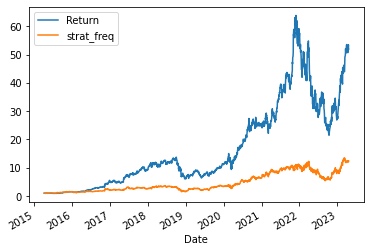

In [11]:
price2[['Return','strat_freq']].cumsum().apply(np.exp).plot()

In [12]:
def sharpe(series):
    mu = (series.apply(np.exp)-1).mean()
    std = (series.apply(np.exp)-1).std()
    return mu/std
print('Compare Sharpe ratios: buy-and-hold: ',sharpe(price2['Return'])
      ,' strategy: ',sharpe(price2['strat_freq']))

Compare Sharpe ratios: buy-and-hold:  0.07885969964147578  strategy:  0.05556147666509002


In [13]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
C=1
models={'log_reg' : linear_model.LogisticRegression(),
       'gauss_nb' : GaussianNB(),
       'svm' : SVC(C=C)}

In [14]:
def fit_models(models):
    mfit = {model: models[model].fit(price2[cols_bin],
                                    price2['direction'])
            for model in models.keys()}
fit_models(models)

In [16]:
warnings.filterwarnings("ignore")
def derive_positions(data):
    for model in models.keys():
        data['pos_'+model]=models[model].predict(data[cols_bin])
derive_positions(price2)
warnings.filterwarnings("default")

<AxesSubplot:xlabel='Date'>

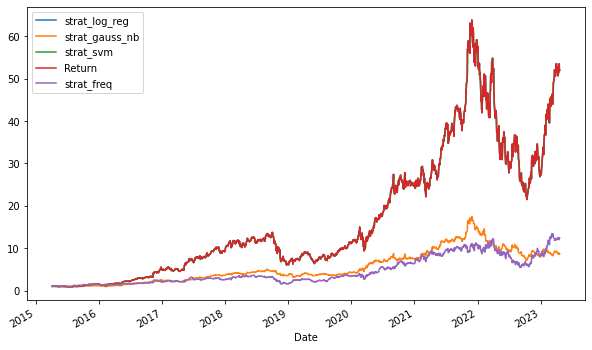

In [17]:
def evaluate_strat(df):
    global strats
    strats=[]
    for model in models.keys():
        name='strat_'+model
        df[name]=df['Return']*df['pos_'+model]
        strats.append(name)
    strats.append('Return')
warnings.filterwarnings("ignore")
evaluate_strat(price2)
warnings.filterwarnings("default")
strats.append('strat_freq')
price2[strats].cumsum().apply(np.exp).plot(figsize=(10,6))

In [19]:
price2[strats].sum().apply(np.exp)

strat_log_reg     51.912418
strat_gauss_nb     8.628578
strat_svm         51.912418
Return            51.912418
strat_freq        12.384996
dtype: float64

In [22]:
df_aapl=yf.download('AAPL','2015-01-01','2023-04-23')
df=df_aapl[['Adj Close']]
df.rename(columns={'Adj Close':'AAPL'},inplace=True)
df['Return']=np.log(df/df.shift(1))
df['directions']=np.sign(df['Return'])
df.dropna(inplace=True)
lags=5
warnings.filterwarnings("ignore")
create_lags(df,lags)
warnings.filterwarnings("default")
df.dropna(inplace=True)
df.head(3)

[*********************100%***********************]  1 of 1 completed


/usr/lib/python3/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_764838/1398433113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return']=np.log(df/df.shift(1))
/tmp/ipykernel_764838/1398433113.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,AAPL,Return,directions,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2015-01-12,24.547716,-0.024950,-1.0,0.001072,0.037702,0.013925,0.000094,-0.028576
2015-01-13,24.765671,0.008840,1.0,-0.024950,0.001072,0.037702,0.013925,0.000094
2015-01-14,24.671307,-0.003818,-1.0,0.008840,-0.024950,0.001072,0.037702,0.013925


In [23]:
create_bins(df)
cols_bin

/tmp/ipykernel_764838/3167866647.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_bin]=np.digitize(df[col],bins=bins)


['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [24]:
df[cols_bin].head(3)

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2015-01-12,1,1,1,1,0
2015-01-13,0,1,1,1,1
2015-01-14,1,0,1,1,1


In [25]:
df.dropna(inplace=True)

/usr/lib/python3/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [27]:
def fit_models(models):
    mfit = {model: models[model].fit(df[cols_bin],
                                    df['directions'])
            for model in models.keys()}
warnings.filterwarnings("ignore")
fit_models(models)
derive_positions(df)
evaluate_strat(df)
warnings.filterwarnings("default")

In [28]:
df[strats].sum().apply(np.exp)

strat_log_reg      8.158807
strat_gauss_nb     1.720165
strat_svm         21.471871
Return             6.556771
dtype: float64

<AxesSubplot:xlabel='Date'>

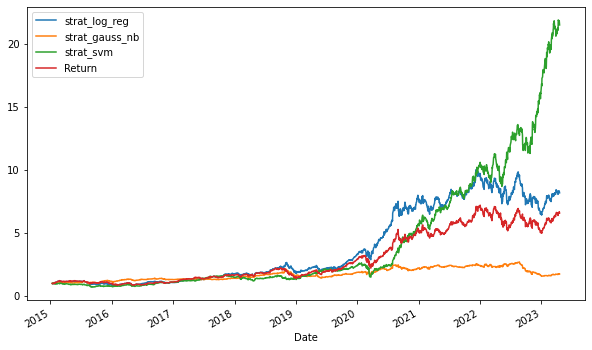

In [29]:
df[strats].cumsum().apply(np.exp).plot(figsize=(10,6))

In [ ]:
#Above suffers from data snooping. Need to split train and test
#for more accurate simulation.

In [30]:
split=len(df)//2
train=df.iloc[:split].copy()
def fit_models(models,dfr):
    mfit = {model: models[model].fit(dfr[cols_bin],
                                    dfr['directions'])
            for model in models.keys()}
warnings.filterwarnings("ignore")
fit_models(models,train)
test=df.iloc[split:].copy()
derive_positions(test)
evaluate_strat(test)
warnings.filterwarnings("default")

In [31]:
test[strats].sum().apply(np.exp)

strat_log_reg     3.746440
strat_gauss_nb    4.335675
strat_svm         5.494759
Return            3.878394
dtype: float64

<AxesSubplot:xlabel='Date'>

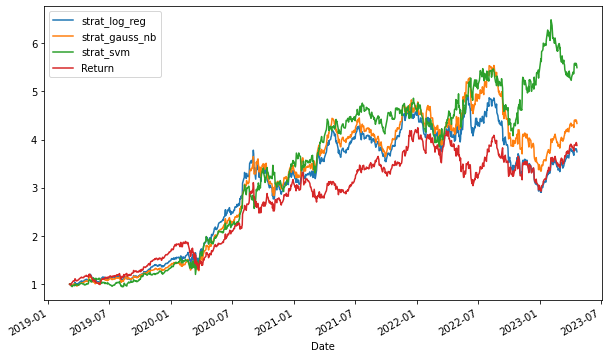

In [32]:
test[strats].cumsum().apply(np.exp).plot(figsize=(10,6))